In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat

import os
import sys
sys.path.append('../utils')

from mTRF_utils import *
from normalize_eeg import *

In [21]:
"""
Concatenates and normalizes EEG data

Saves a .mat file with task- and period-specific EEG for all participants.
Also optionally saves a .mat file with the nonnormalized, task and period specific EEG concatenated for all participants

"""
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import pickle

import os
import sys
sys.path.append('../utils')
from mTRF_utils import *
from pp_utils import *


def normalize_eeg_stimuli(subjects_to_process, task, period, overwrite = False, save_concatenated_original = False, save_normalized = False):
    """
    Normalizes eeg responses across subjects.
    Option to save the normalized lists of responses and stimuli

    Returns: eeg_list_normalized (a list of n_timepoints x n_channel arrays)

    """
    #======================================================================================
    #                        INITIALIZE DIRECTORIES
    #======================================================================================
    pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
    normalized_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/normalization'

    #======================================================================================
    #                        CONCATENATE AND NORMALIZE
    #======================================================================================
    #initialize lists for saving
    eeg_list = []
    stimuli_list = []
    

    for folder in sorted(os.listdir(pp_dir)):
        
        if folder not in subjects_to_process:
            continue
        
        sub_pp_dir = os.path.join(pp_dir, folder)
        print('\nPROCESSING SUBJECT ', folder)


        data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]
        subject_ID = data_path.split('.')[0][-2:]
        print('Opening', data_path.split('/')[-1])
        
        #--------------------------------------------
        #               LOAD FILE AND EVENTS
        #--------------------------------------------
        data = loadmat(data_path)
        eeg = data['trial_data'].T #only the 64 eeg channels, no ext channels
        events_sv = data['events']

        # EEG
        ##########################
        #append eeg to master list
        eeg_list.append(eeg)

        # ONSETS
        ########################
        events_arr = make_raw_events(events_sv)
        events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
        onset_indices = events_keystrokes[:,0]

        #make support vector
        onsets_sv = np.zeros_like(events_sv[0])
        onsets_sv[onset_indices] = 1

        # SURPRISAL
        ########################
        #loading surprisal values from DREX
        with open ('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/mTRF_stimuli/listen_surprisal_drex.pkl', 'rb') as f:
            surprisal_drex = pickle.load(f)
        surprisal_drex = surprisal_drex.squeeze()

        #make support vector
        index_surprisal = 0
        surprisal_sv  = []
        for num in onsets_sv:
            if num == 1:
                surprisal_sv.append(surprisal_drex[index_surprisal])
                index_surprisal += 1
            else:
                surprisal_sv.append(num)
        surprisal_sv = np.array(surprisal_sv)

       
        # STACKING STIMULUS FEATURES
        stacked_sv = np.vstack([onsets_sv, surprisal_sv])

        
        #append to events master list
        stimuli_list.append(stacked_sv.T)

    eeg_list_normalized = normalize_responses(eeg_list)
    stimuli_list_normalized = normalize_stimuli(stimuli_list)

    #SAVE FILES
    #======================================================================================

    if save_normalized == True:
        file_tosave = os.path.join(normalized_dir,f'normalized_concat_{task}_{period}.mat')
        os.path.exists(file_tosave)

        mat_tosave = {'eeg_normalized': eeg_list_normalized,
                    'subjects': subjects_to_process,
                    }
        if save_concatenated_original:
            mat_tosave['eeg_original': eeg_list]

        if overwrite == False and os.path.exists(file_tosave):
            print('File already exists. Choose another file name or set Overwrite to True')
        else:
            savemat(file_tosave, mat_tosave)

    return eeg_list_normalized, stimuli_list_normalized

In [23]:
eeg_list ,stimuli_list = normalize_eeg_stimuli(subjects_to_process, 'listen', 'pre')


PROCESSING SUBJECT  01
Opening eeg_listen_pre_01.mat

PROCESSING SUBJECT  02
Opening eeg_listen_pre_02.mat


In [25]:
stimuli_list[0].shape

(85120, 2)

In [27]:
import matplotlib.pyplot as plt

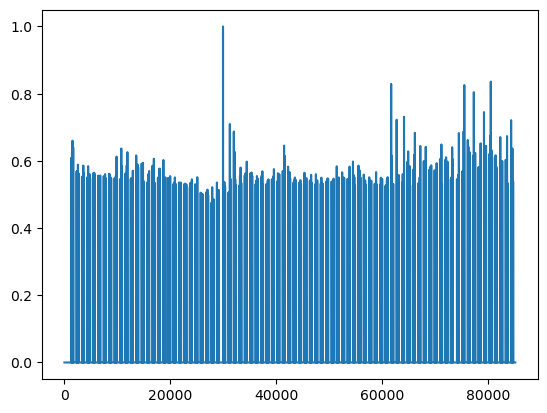

In [29]:
plt.plot(stimuli_list[0][:,1])